In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1' # specify GPUs locally

OUTPUT_DIR = './submission'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
dataset_path = './data/ganhackerton/dataset'

In [3]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [4]:
import pandas as pd
dfall = pd.concat([pd.read_csv(dataset_path + f'/dataindex_{i:0>2}.csv') for i in range(0, 37)]).drop('Unnamed: 0',axis=1)

In [5]:
import re
dfall['path'] = dfall['path'].apply(lambda x: dataset_path + x.split('dataset')[1])

dfall['polygon1_x'] = dfall['polygon1'].apply(lambda x: re.findall(r"'x': (\d+.\d+)", x))
dfall['polygon1_y'] = dfall['polygon1'].apply(lambda y: re.findall(r"'y': (\d+.\d+)", y))

dfall['polygon2_x'] = dfall['polygon2'].apply(lambda x: re.findall(r"'x': (\d+.\d+)", x))
dfall['polygon2_y'] = dfall['polygon2'].apply(lambda y: re.findall(r"'y': (\d+.\d+)", y))

In [6]:
dfall.head()

,id,basestyle,basestyle-type,length,curl,bang,loss,side,age,front,...,exifdata.samples_per_pixel,exifdata.white_point,exifdata.primary_chromaticities,exifdata.matrix_coefficients,exifdata.<unknown EXIF tag 59932>,exifdata.<unknown EXIF tag 316>,polygon1_x,polygon1_y,polygon2_x,polygon2_y
0,ba4ddeaf-b395-4c2b-b409-02cd456059ab,여자일반숏,장,여숏,S,풀뱅,탈모아님,원블럭,59,False,...,NaN,NaN,NaN,NaN,NaN,NaN,"[225.67494201660156, 243.72891235351562, 249.3...","[8.536154747009277, 10.792903900146484, 17.563...","[271.93829345703125, 330.61376953125, 349.7961...","[112.34662628173828, 95.4209976196289, 117.988..."
1,3ef2a954-1d6a-4700-9317-79f52b40aaca,여자일반숏,장,여숏,S,풀뱅,탈모아님,원블럭,59,False,...,NaN,NaN,NaN,NaN,NaN,NaN,"[218.8034210205078, 193.9289093017578, 190.704...","[79.89250183105469, 80.81377410888672, 81.7350...","[197.1533966064453, 210.5119171142578, 209.590...","[89.10527038574219, 97.39677429199219, 125.035..."
2,7e553b3b-ae20-4f49-b916-cb57a4d04381,여자일반숏,장,여숏,S,풀뱅,탈모아님,원블럭,59,False,...,NaN,NaN,NaN,NaN,NaN,NaN,"[275.7973327636719, 266.82513427734375, 259.02...","[73.92304992675781, 59.489524841308594, 52.467...","[135.36305236816406, 164.6201934814453, 170.47...","[148.04115295410156, 167.54591369628906, 188.6..."
3,b50fe8c5-3798-4bb0-ad31-69d49b7c515c,여자일반숏,장,여숏,S,풀뱅,탈모아님,원블럭,59,False,...,NaN,NaN,NaN,NaN,NaN,NaN,"[287.36480712890625, 299.9808349609375, 306.98...","[207.81382751464844, 174.17111206054688, 141.9...",[],[]
4,bd67e6a9-13f1-4258-ab04-e183d9e11892,여자일반숏,장,여숏,S,풀뱅,탈모아님,원블럭,59,False,...,NaN,NaN,NaN,NaN,NaN,NaN,"[279.8369140625, 291.12066650390625, 301.27603...","[12.130027770996094, 11.001652717590332, 12.13...","[192.95205688476562, 225.67494201660156, 233.5...","[93.37300109863281, 100.14324951171875, 129.48..."


In [50]:
from PIL import Image, ImageDraw

k, width, height = 5, 512, 512
img = Image.new('L', (width, height), 0)
ImageDraw.Draw(img).polygon([(float(x), float(y)) for x, y in zip(dfall['polygon1_x'].iloc[k], dfall['polygon1_y'].iloc[k])], outline=1, fill=1)
mask = np.array(img)

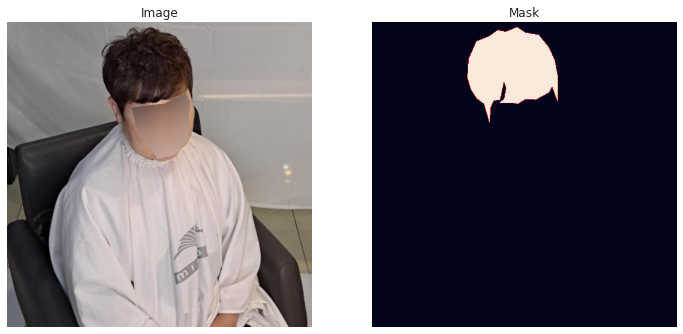

In [51]:
fig = plt.figure(figsize=(12, 8))
rows, cols = 1, 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(cv2.imread(dfall['path'].iloc[k]), cv2.COLOR_BGR2RGB))
ax1.set_title('Image')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(mask)
ax2.set_title('Mask')
ax2.axis("off")
plt.show()

In [52]:
dataset_path = './data/CelebAMask-HQ'
data = pd.DataFrame() 
data['images'] = [dataset_path + '/images/' + c for c in sorted(os.listdir(dataset_path + '/images'))]
data['masks'] = [dataset_path + '/masks/' + c.split('.')[0] + '.png' for c in sorted(os.listdir(dataset_path + '/images'))]

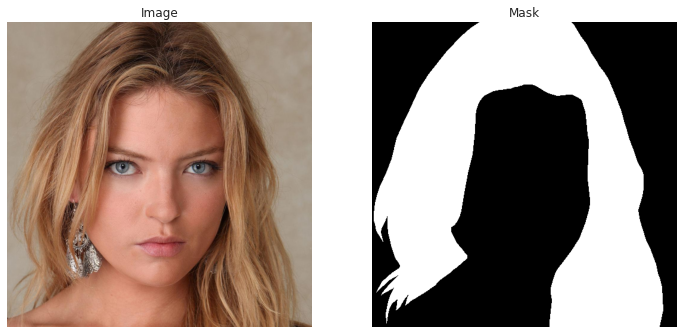

In [53]:
fig = plt.figure(figsize=(12, 8))
rows, cols = 1, 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(cv2.imread(data['images'].iloc[k]), cv2.COLOR_BGR2RGB))
ax1.set_title('Image')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.imread(data['masks'].iloc[k]))
ax2.set_title('Mask')
ax2.axis("off")
plt.show()